The inspiration for this project came from https://www.sciencedirect.com/science/article/pii/S1877050920304865.

Some references used:

https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/

https://www.investopedia.com/terms/m/macd.asp

https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/RSI

https://neptune.ai/blog/predicting-stock-prices-using-machine-learning

# **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import load_model

# **Load and Read an Initial CSV File with Apple's (AAPL) Stock Data**

In [2]:
data = pd.read_csv('AAPL_historical_data.csv', parse_dates=['Date'], index_col='Date')

print(data.describe())

              Open         High          Low        Close    Adj Close  \
count  3690.000000  3690.000000  3690.000000  3690.000000  3690.000000   
mean     66.001299    66.704383    65.334160    66.048135    63.907784   
std      61.090062    61.759734    60.478807    61.149000    61.499889   
min       6.870357     7.000000     6.794643     6.858929     5.792196   
25%      20.290268    20.434375    20.034821    20.274822    17.294510   
50%      36.008749    36.209999    35.807501    35.993750    33.590803   
75%     123.625002   124.965002   122.064999   123.502501   121.099709   
max     236.479996   237.229996   233.089996   234.820007   234.548523   

             Volume  
count  3.690000e+03  
mean   2.340612e+08  
std    2.187281e+08  
min    2.404830e+07  
25%    8.760190e+07  
50%    1.437499e+08  
75%    3.152062e+08  
max    1.880998e+09  


Check if there are null, empty, and missing values. If so, remove them.

In [21]:
print(data.isnull().sum())
data = data.dropna()

Price      Ticker
Date                 0
Adj Close  AAPL      0
Close      AAPL      0
High       AAPL      0
Low        AAPL      0
Open       AAPL      0
Volume     AAPL      0
dtype: int64


# **Calculate Additional Features**


*   Moving Average (MA, 5 day and 30 day)
*   Exponential Average (EA, 5 day and 30 day)
*   Relative Strength Index (RSI)
*   Moving Average Convergence/Divergence (MACD)
*   Volume Moving Average (VMA, 20 day)

All of these terms and their significance will be explained in the analysis section below.



In [5]:
data["MA_5"] = data["Close"].rolling(window=5).mean()
data["MA_30"] = data["Close"].rolling(window=30).mean()
data["EA_5"] = data["Close"].ewm(span=5, adjust=False).mean()
data["EA_30"] = data["Close"].ewm(span=30, adjust=False).mean()

In [6]:
def calculate_RSI(data, window=14):
    delta = data["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

data['RSI'] = calculate_RSI(data)

In [7]:
data["MACD"] = data["Close"].ewm(span=12, adjust=False).mean() - data["Close"].ewm(span=26, adjust=False).mean()

data["VMA_20"] = data["Volume"].rolling(window=20).mean()

data.dropna(inplace=True)

data

,Open,High,Low,Close,Adj Close,Volume,MA_5,MA_30,EA_5,EA_30,RSI,MACD,VMA_20
Date,,,,,,,,,,,,,
2010-02-16,7.212143,7.274643,7.197143,7.264286,6.134510,543737600,7.098286,7.275952,7.130884,7.234672,-900.396339,-0.100518,840474600.0
2010-02-17,7.292500,7.296786,7.173571,7.233929,6.108872,436396800,7.143714,7.262310,7.165233,7.234624,-392.683495,-0.082892,825794060.0
2010-02-18,7.201071,7.281786,7.175714,7.247500,6.120335,422825200,7.199500,7.248679,7.192655,7.235455,585.438140,-0.067056,816327680.0
2010-02-19,7.209286,7.257143,7.182500,7.202500,6.082334,415469600,7.220929,7.237607,7.195937,7.233329,221.747998,-0.057475,806693440.0
2010-02-22,7.226429,7.232143,7.113929,7.157857,6.044633,390563600,7.221214,7.225512,7.183243,7.228460,327.591976,-0.052874,782133240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,226.759995,227.279999,223.889999,227.179993,227.179993,30602200,226.291995,221.233334,226.119636,220.890396,110.726816,2.382962,51773160.0
2024-08-27,226.000000,228.850006,224.889999,228.029999,228.029999,35934600,226.595996,221.007000,226.756424,221.351016,111.751787,2.533158,51487700.0
2024-08-28,227.919998,229.860001,225.679993,226.490005,226.490005,38052200,226.613998,220.927334,226.667618,221.682564,127.921020,2.499116,50888495.0


# **Exploratory Data Analysis**

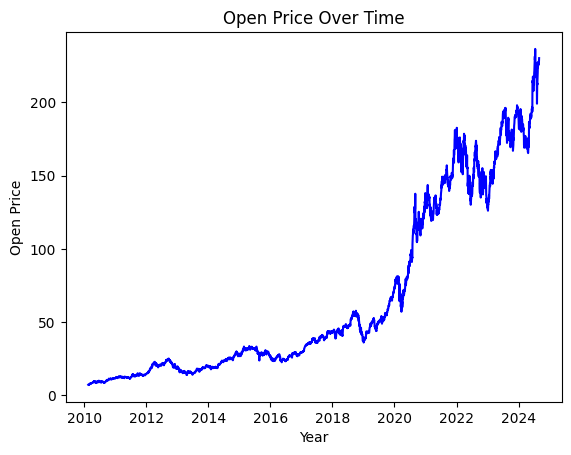

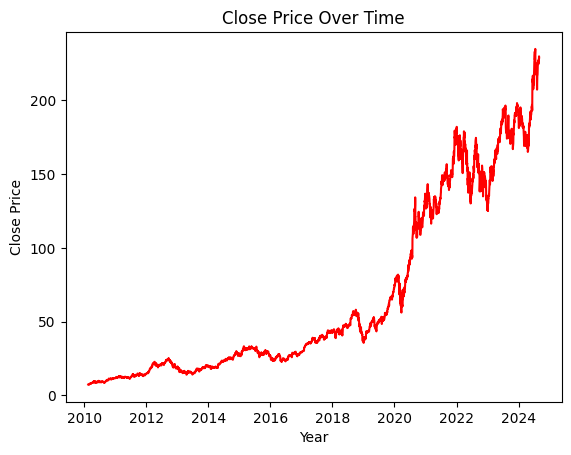

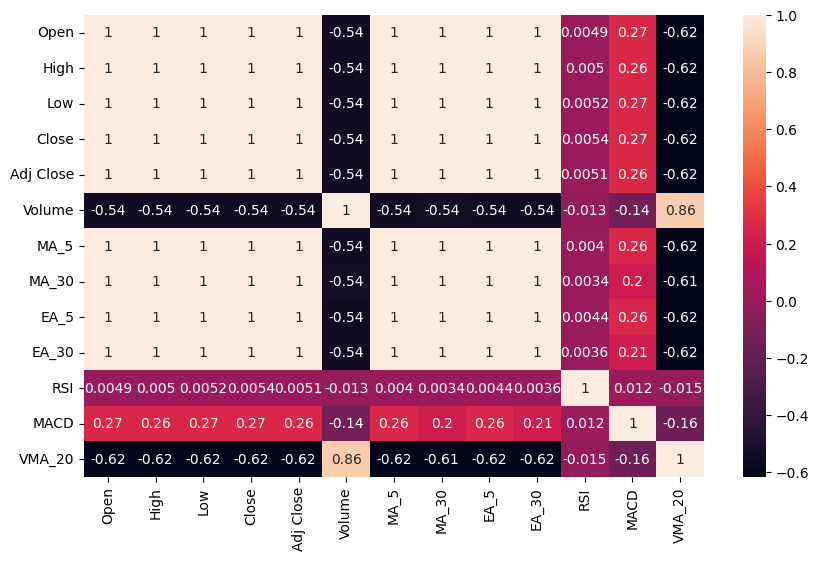

In [8]:
plt.figure()
plt.plot(data["Open"], color='blue', label='Open Price')
plt.title("Open Price Over Time")
plt.xlabel("Year")
plt.ylabel("Open Price")
plt.show()

plt.figure()
plt.plot(data["Close"], color='red', label='Close Price')
plt.title("Close Price Over Time")
plt.xlabel("Year")
plt.ylabel("Close Price")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True)
plt.show()

                Open      High       Low     Close    Volume      MA_5  \
Date                                                                     
2010-03-29  0.000028  0.000000  0.005116  0.000000  0.278250  0.000000   
2010-03-30  0.000592  0.000563  0.005532  0.000546  0.271015  0.000239   
2010-03-31  0.000418  0.000428  0.005565  0.000412  0.218967  0.000419   
2010-04-01  0.000718  0.000758  0.005295  0.000564  0.311854  0.000716   
2010-04-05  0.000338  0.000724  0.005614  0.000962  0.355669  0.000958   

               MA_30      EA_5     EA_30       RSI      MACD    VMA_20  
Date                                                                    
2010-03-29  0.000000  0.000000  0.000000  0.464730  0.440488  0.552576  
2010-03-30  0.000180  0.000336  0.000179  0.464690  0.441256  0.550342  
2010-03-31  0.000360  0.000515  0.000338  0.464754  0.441542  0.553678  
2010-04-01  0.000544  0.000686  0.000497  0.464758  0.441779  0.567178  
2010-04-05  0.000748  0.000934  0.000672  0

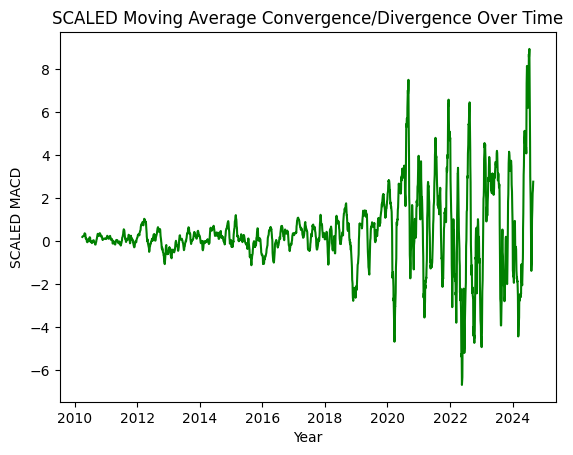

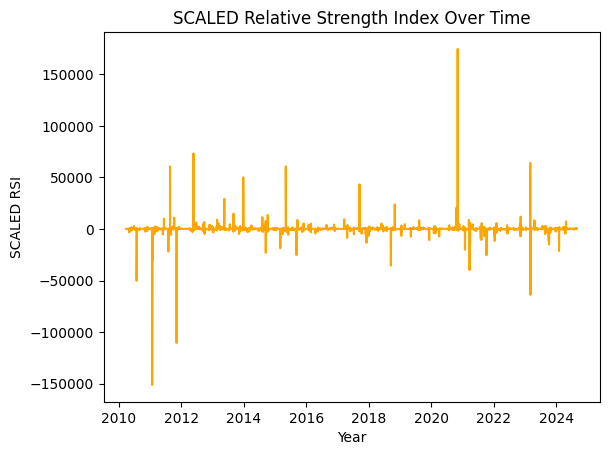

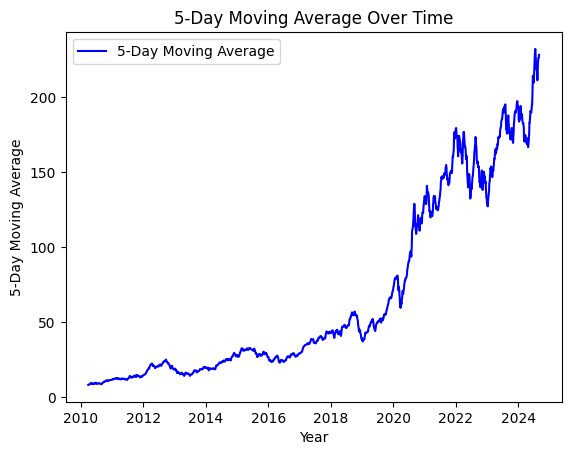

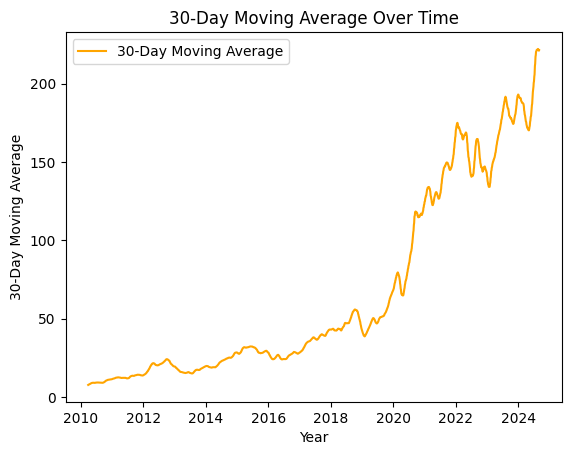

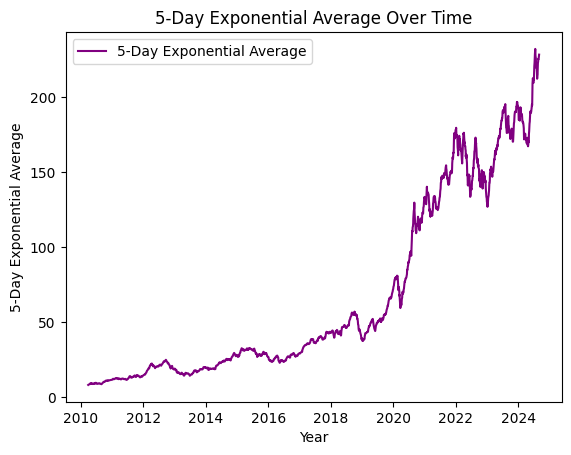

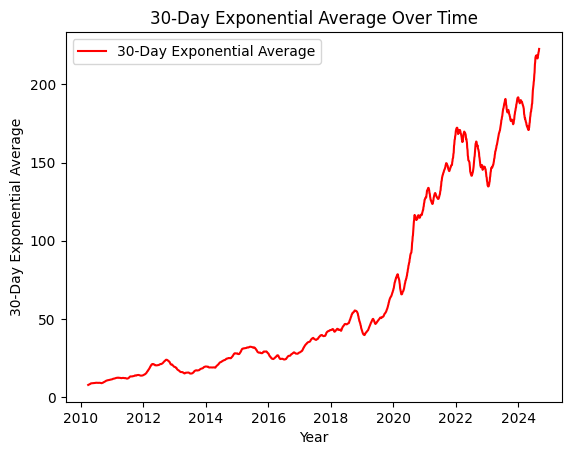

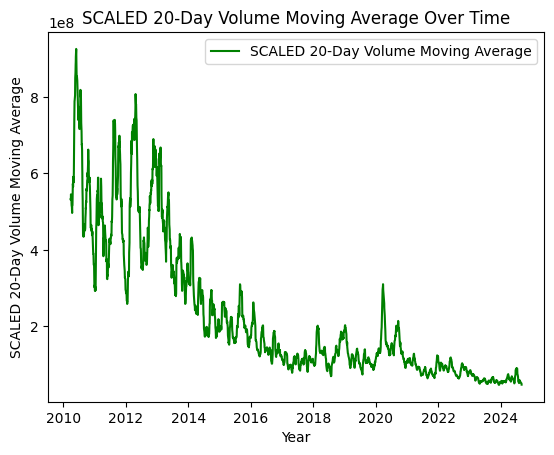

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
features = ["Open", "High", "Low", "Close", "Volume", "MA_5", "MA_30", "EA_5", "EA_30", "RSI", "MACD", "VMA_20"]


data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()

data['VMA_20'] = data['Volume'].rolling(window=20).mean()

data['MA_5'] = data['Close'].rolling(window=5).mean()

data['MA_30'] = data['Close'].rolling(window=30).mean()

data['EA_5'] = data['Close'].ewm(span=5, adjust=False).mean()

data['EA_30'] = data['Close'].ewm(span=30, adjust=False).mean()


data = data.dropna(subset=["RSI"])
data[features] = data[features].replace([np.inf, -np.inf], np.nan)
data = data.dropna(subset=features)

scaler = MinMaxScaler(feature_range=(0, 1))
features = ["Open", "High", "Low", "Close", "Volume", "MA_5", "MA_30", "EA_5", "EA_30", "RSI", "MACD", "VMA_20"]

scaled_data = scaler.fit_transform(data[features])

scaled_df = pd.DataFrame(scaled_data, index=data.index, columns=features)

print(scaled_df.head())

plt.figure()
plt.plot(data["MACD"], color='green', label='SCALED Moving Average Convergence/Divergence')
plt.title("SCALED Moving Average Convergence/Divergence Over Time")
plt.xlabel("Year")
plt.ylabel("SCALED MACD")
plt.show()

plt.figure()
plt.plot(data["RSI"], color='orange', label='SCALED Relative Strength Index')
plt.title("SCALED Relative Strength Index Over Time")
plt.xlabel("Year")
plt.ylabel("SCALED RSI")
plt.show()

plt.figure()
plt.plot(data["MA_5"], color='blue', label='5-Day Moving Average')
plt.title("5-Day Moving Average Over Time")
plt.xlabel("Year")
plt.ylabel("5-Day Moving Average")
plt.legend()
plt.show()

plt.figure()
plt.plot(data["MA_30"], color='orange', label='30-Day Moving Average')
plt.title("30-Day Moving Average Over Time")
plt.xlabel("Year")
plt.ylabel("30-Day Moving Average")
plt.legend()
plt.show()

plt.figure()
plt.plot(data["EA_5"], color='purple', label='5-Day Exponential Average')
plt.title("5-Day Exponential Average Over Time")
plt.xlabel("Year")
plt.ylabel("5-Day Exponential Average")
plt.legend()
plt.show()

plt.figure()
plt.plot(data["EA_30"], color='red', label='30-Day Exponential Average')
plt.title("30-Day Exponential Average Over Time")
plt.xlabel("Year")
plt.ylabel("30-Day Exponential Average")
plt.legend()
plt.show()

# Plot VMA_20
plt.figure()
plt.plot(data["VMA_20"], color='green', label='SCALED 20-Day Volume Moving Average')
plt.title("SCALED 20-Day Volume Moving Average Over Time")
plt.xlabel("Year")
plt.ylabel("SCALED 20-Day Volume Moving Average")
plt.legend()
plt.show()

# **Data Analysis**

After conducting thorough analysis for the AAPL stock price from 2010 - 2024. There are a few trends that can be noticed. First of all, the open price and close price move in a relatively similar trend over time. The next metric which was analyzed was Moving Average Convergence/Divergence (MACD). This is an oscillator function, which in the financial world which allows investors to analyze a security's price and identify trends, momentum, and appropriate points to buy or sell. An MACD of 0 indicates that the stock is relatively stable, whereas, an MACD that differs from 0 indicates volatility. This is calculated by subtracting the 26 day exponential moving average from it's 12 day exponential moving average. Please note that in this example, MACD is scaled to optimize model training. The 5 day moving/exponential average and 30 day moving/exponential average was also analyzed. Relative Strength Index (RSI) is a technical indicator (another momentum oscillator) which is calculated over a 14 day period and divides the average gains by the average losses. A positive RSI indicates that the stock may be overbought or overvalued, a negative RSI indicates that a stock may be oversold or undervalued, while a 0 value indicates a balance between bullish and bearish positions. Please note that RSI is typically a score between 0 to 100, however, in this example, it is scaled a specific way to to optimize model training. The next metric that was analyzed was the 20-day volume moving average (VMA) which was again scaled to help with model training. Volume is the number of transactions which occur for a particular stock. Thus, volume moving average helps identify general buying/selling trends over a long-term time frame. Furthermore, a heatmap is printed to attempt to identify trends in the data. One relationship that stands out is Volume and VMA_20 have a score of 0.86, which makes sense since VMA_20 is a moving average of volume. Through this analysis, we will have the model scale these values and give greater emphasis on the moving averages, open/close prices (since they follow similar patterns), and have other factors like RSI, MACD, and VMA help with finetuning of the model. These would all serve as ways to feature-engineer the model that is being built. Some key insights include that MACD, RSI, and VMA all give an extremely strong "buy" signal near 2020. This is especially seen as the scaled RSI value nears 150000. All of this will be useful as the model is being trained and finetuned. First, a few preliminary models will be created like Linear Regression, Support Vector Regression, etc to play around with training/testing. However, for advanced time-series data like this, a specific kind of RNN known as Long-Short Term Memory (LSTM) will prove to be useful as it analyzes short-term fluctuations and long-term output changes while trajning a data instead of just focusing on one portion of overall trend.

# **Train Test Split**

In [10]:
scaled_df["Target"] = scaled_df["Close"].shift(-1)

scaled_df.dropna(inplace=True)

print(scaled_df.head())

X = scaled_df.drop(["Target"], axis=1)
y = scaled_df["Target"]

#As per the standard 80% in train size and 20% in test size:
train_size = int(len(X) * 0.8)

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("\n")
#VERIFY
print(f'Training data: {len(X_train)}')
print(f'Testing data: {len(X_test)}')

                Open      High       Low     Close    Volume      MA_5  \
Date                                                                     
2010-03-29  0.000028  0.000000  0.005116  0.000000  0.278250  0.000000   
2010-03-30  0.000592  0.000563  0.005532  0.000546  0.271015  0.000239   
2010-03-31  0.000418  0.000428  0.005565  0.000412  0.218967  0.000419   
2010-04-01  0.000718  0.000758  0.005295  0.000564  0.311854  0.000716   
2010-04-05  0.000338  0.000724  0.005614  0.000962  0.355669  0.000958   

               MA_30      EA_5     EA_30       RSI      MACD    VMA_20  \
Date                                                                     
2010-03-29  0.000000  0.000000  0.000000  0.464730  0.440488  0.552576   
2010-03-30  0.000180  0.000336  0.000179  0.464690  0.441256  0.550342   
2010-03-31  0.000360  0.000515  0.000338  0.464754  0.441542  0.553678   
2010-04-01  0.000544  0.000686  0.000497  0.464758  0.441779  0.567178   
2010-04-05  0.000748  0.000934  0.000

# **Linear Regression**

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

lr_preds = lr_model.predict(X_test)

lr_mse = mean_squared_error(y_test, lr_preds)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, lr_preds)

print(f'RMSE: {lr_rmse}')
print(f'MSE: {lr_mse}')
print(f'MAE: {lr_mae}')

RMSE: 0.012877177504185336
MSE: 0.0001658217004742969
MAE: 0.009713050297011529


# **Random Forest Model**

In [12]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_preds)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_preds)

print(f'RMSE: {rf_rmse}')
print(f'MSE: {rf_mse}')
print(f'MAE: {rf_mae}')

RMSE: 0.12298881984124657
MSE: 0.015126249805942606
MAE: 0.09119338767752812


# **Support Vector Regression**

In [13]:
from sklearn.svm import SVR

svr_model = SVR(kernel="rbf")

svr_model.fit(X_train, y_train)

svr_preds = svr_model.predict(X_test)

svr_mse = mean_squared_error(y_test, svr_preds)
svr_rmse = np.sqrt(svr_mse)
svr_mae = mean_absolute_error(y_test, svr_preds)

print(f'RMSE: {svr_rmse}')
print(f'MSE: {svr_mse}')
print(f'MAE: {svr_mae}')

RMSE: 0.2958292004449596
MSE: 0.08751491583590408
MAE: 0.2527046101400637


**MODIFYING THE DATA A BIT FOR LSTM MODEL**

In [15]:
start = '2012-01-01'
end = '2022-12-21'
stock = 'AAPL'

data = yf.download(stock, start, end)
data.reset_index(inplace=True)
data['Date'] = data.index
ma_100_days = data.Close.rolling(100).mean()
ma_200_days = data.Close.rolling(200).mean()

data.dropna(inplace=True)

data_train = pd.DataFrame(data.Close[0: int(len(data)*0.80)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])
scaler = MinMaxScaler(feature_range=(0,1))
data_train_scale = scaler.fit_transform(data_train)

x = []
y = []

for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])

x, y = np.array(x), np.array(y)


[*********************100%***********************]  1 of 1 completed


# **Building, Training, and Saving the Model**

In [16]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,
               input_shape = ((x.shape[1],1))))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation='relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units =1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x,y, epochs = 50, batch_size =32, verbose =1)
model.summary()

model.save('stock_prediction_lstm_aapl.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 273ms/step - loss: 0.0311
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 278ms/step - loss: 0.0040
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 288ms/step - loss: 0.0021
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - loss: 0.0027
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 258ms/step - loss: 0.0027
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 288ms/step - loss: 0.0029
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 259ms/step - loss: 0.0026
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 267ms/step - loss: 0.0023
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 293ms/step - loss: 0.0028
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 259ms/step - loss: 0.0024
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 275ms/step - loss: 0.0019
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 257ms/step - loss: 0.0021
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 276ms/step - loss: 0.0023
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - loss: 0.0017
Epoch 15/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 60)             │          26,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 60)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 80)             │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 120)                 │          96,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 536,285 (2.05 MB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 357,524 (1.36 MB)

# **Running the Model to Predict Price on the Testing Data**

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step


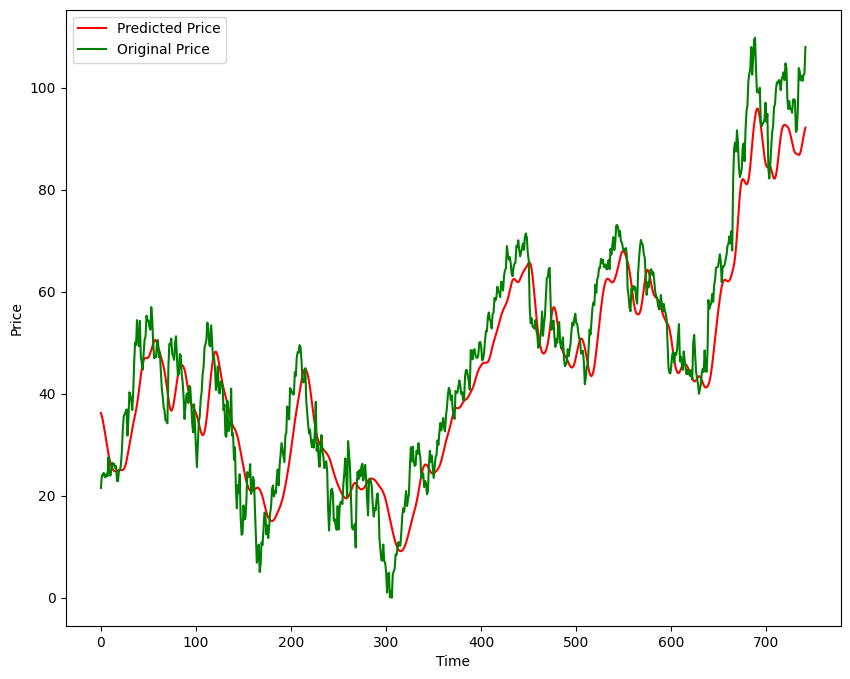

In [19]:
model = tf.keras.models.load_model('stock_prediction_lstm_aapl.h5')

pas_100_days = data_train.tail(100)
data_test = pd.concat([pas_100_days, data_test], ignore_index=True)
data_test_scale  =  scaler.fit_transform(data_test)

x = []
y = []

for i in range(100, data_test_scale.shape[0]):
    x.append(data_test_scale[i-100:i])
    y.append(data_test_scale[i,0])
x, y = np.array(x), np.array(y)

y_predict = model.predict(x)

scale =1/scaler.scale_
y_predict = y_predict*scale

y = y*scale

plt.figure(figsize=(10,8))
plt.plot(y_predict, 'r', label = 'Predicted Price')
plt.plot(y, 'g', label = 'Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed

 1/21 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


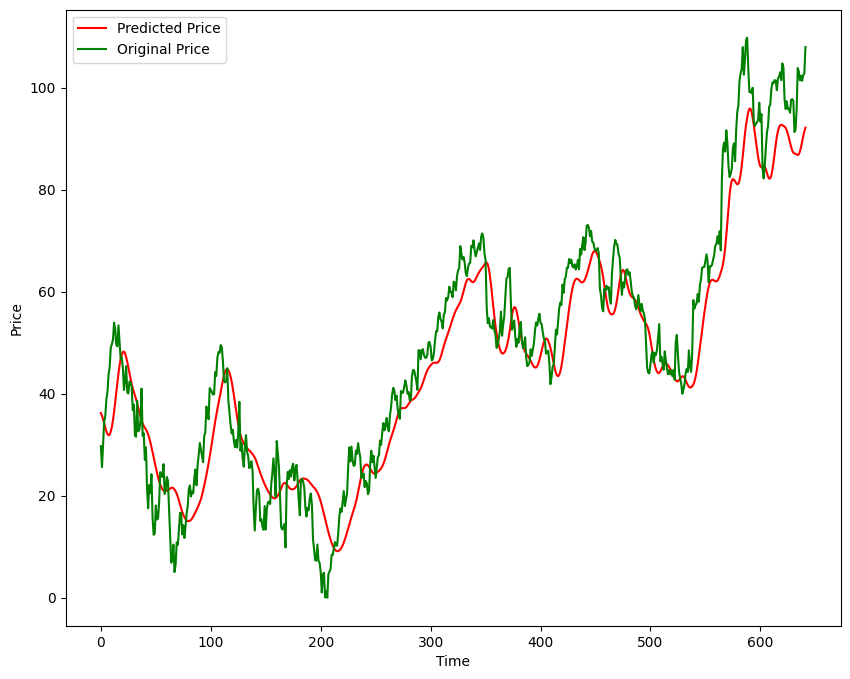

In [20]:
start = '2012-01-01'
end = '2024-10-01'
stock = 'AAPL'

data = yf.download(stock, start, end)
data.reset_index(inplace=True)
data['Date'] = data.index
ma_100_days = data.Close.rolling(100).mean()
ma_200_days = data.Close.rolling(200).mean()

data.dropna(inplace=True)

data_train = pd.DataFrame(data.Close[0: int(len(data)*0.80)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])
scaler = MinMaxScaler(feature_range=(0,1))
data_train_scale = scaler.fit_transform(data_train)

x = []
y = []

for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])

x, y = np.array(x), np.array(y)

pas_100_days = data_train.tail(100)
data_test = pd.concat([pas_100_days, data_test], ignore_index=True)
data_test_scale  =  scaler.fit_transform(data_test)

x = []
y = []

for i in range(100, data_test_scale.shape[0]):
    x.append(data_test_scale[i-100:i])
    y.append(data_test_scale[i,0])
x, y = np.array(x), np.array(y)

y_predict = model.predict(x)

scale =1/scaler.scale_
y_predict = y_predict*scale

y = y*scale

plt.figure(figsize=(10,8))
plt.plot(y_predict, 'r', label = 'Predicted Price')
plt.plot(y, 'g', label = 'Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
